# Predicting personal financial distress

## Context

### Introduction

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. 

We want to build a model that borrowers can use to help make the best financial decisions, by predicting the probability that somebody will experience financial distress in the next two years.

### Data explanation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

The dataset obtained from https://www.kaggle.com/c/GiveMeSomeCredit contains 11 fields for 150,000 people. 

SeriousDlqin2yrs: Person experienced 90 days past due delinquency or worse

RevolvingUtilizationOfUnsecuredLines: Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits

age: Age of borrower in years

NumberOfTime30-59DaysPastDueNotWorse: Number of times borrower has been 30-59 days past due but no worse in the last 2 years.

DebtRatio: Monthly debt payments, alimony,living costs divided by monthy gross income

MonthlyIncome: Monthly income

NumberOfOpenCreditLinesAndLoans: Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)

NumberOfTimes90DaysLate: Number of times borrower has been 90 days or more past due.

NumberRealEstateLoansOrLines: Number of mortgage and real estate loans including home equity lines of credit

NumberRealEstateLoansOrLines: Number of mortgage and real estate loans including home equity lines of credit

NumberOfTime60-89DaysPastDueNotWorse: Number of times borrower has been 60-89 days past due but no worse in the last 2 years.

NumberOfDependents: Number of dependents in family excluding themselves (spouse, children etc.)

We would construct several classification models, trying to predict whether a person would experience 90 days past due delinquency or worse.

### Explore data

In [2]:
df = pd.read_csv("cs-training.csv")
df.head(20)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


In [3]:
# We drop the index column
df = df.drop(df.columns[0], axis=1)

In [4]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


We have missing values for MonthlyIncome and NumberOfDependents. There are 3 ways to deal with it: 
 1. Replace missing values with average 
 2. Drop observation that has misisng values
 3. Turn missing values to 0 and add new columns MissingMonthlyIncome and MissingNumberOfDependents that has value 0 or 1 depends on whether that observation has null MonthlyIncome or NumberOfDependents. (This approach would introduce the impact of missing values in prediction and we expect it to work the best since there are a lot if missing values)

In [5]:
# Add MissingMonthlyIncome and MissingNumberOfDependents column
df['MissingMonthlyIncome'] = np.where(df['MonthlyIncome'].isnull(), 0, 1)
df['MissingNumberOfDependents'] = np.where(df['NumberOfDependents'].isnull(), 0, 1)

# Replace missing income with average and missing number of dependent with 0
meanIncome = df['MonthlyIncome'].mean()
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(value=meanIncome)
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(value=0)

In [6]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MissingMonthlyIncome,MissingNumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.737413,0.801793,0.973840
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.288045e+04,5.145951,4.169304,1.129771,4.155179,1.107021,0.398650,0.159611
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,6.600000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000,1.000000,1.000000


The min of age is 0 and since age < 16 does not make sense, we'll need to explore and clean up the value.

In [7]:
# Count the number of people with age < 16 
df[df['age'] < 16].count()

SeriousDlqin2yrs                        1
RevolvingUtilizationOfUnsecuredLines    1
age                                     1
NumberOfTime30-59DaysPastDueNotWorse    1
DebtRatio                               1
MonthlyIncome                           1
NumberOfOpenCreditLinesAndLoans         1
NumberOfTimes90DaysLate                 1
NumberRealEstateLoansOrLines            1
NumberOfTime60-89DaysPastDueNotWorse    1
NumberOfDependents                      1
MissingMonthlyIncome                    1
MissingNumberOfDependents               1
dtype: int64

In [8]:
# We drop the one observation where age < 16
df = df[df['age'] > 15]

In [9]:
# We check the correlation of the predictors with SeriousDlqin2yrs
df.corr()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MissingMonthlyIncome,MissingNumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001802,-0.115397,0.125587,-0.007602,-1.800181e-02,-0.029669,0.117175,-0.007037,0.102261,0.046871,2.130925e-02,1.392838e-02
RevolvingUtilizationOfUnsecuredLines,-0.001802,1.000000,-0.005899,-0.001313,0.003961,6.564999e-03,-0.011281,-0.001061,0.006235,-0.001048,0.001193,-1.196335e-03,-3.082129e-03
age,-0.115397,-0.005899,1.000000,-0.062995,0.024185,3.298417e-02,0.147700,-0.061009,0.033172,-0.057163,-0.215677,-1.368878e-01,-8.092607e-02
NumberOfTime30-59DaysPastDueNotWorse,0.125587,-0.001313,-0.062995,1.000000,-0.006542,-7.635503e-03,-0.055312,0.983603,-0.030565,0.987006,-0.004591,-1.883555e-02,-1.904610e-02
DebtRatio,-0.007602,0.003961,0.024185,-0.006542,1.000000,-5.355015e-03,0.049565,-0.008320,0.120047,-0.007533,-0.044475,-3.221560e-01,-5.877768e-02
MonthlyIncome,-0.018002,0.006565,0.032984,-0.007636,-0.005355,1.000000e+00,0.082319,-0.009484,0.113824,-0.008259,0.058193,1.724760e-07,5.685589e-08
NumberOfOpenCreditLinesAndLoans,-0.029669,-0.011281,0.147700,-0.055312,0.049565,8.231882e-02,1.000000,-0.079985,0.433963,-0.071077,0.074030,1.194898e-01,9.072656e-02
NumberOfTimes90DaysLate,0.117175,-0.001061,-0.061009,0.983603,-0.008320,-9.483588e-03,-0.079985,1.000000,-0.045205,0.992796,-0.011962,-2.607292e-02,-2.235345e-02
NumberRealEstateLoansOrLines,-0.007037,0.006235,0.033172,-0.030565,0.120047,1.138239e-01,0.433963,-0.045205,1.000000,-0.039722,0.129394,6.458415e-02,6.198324e-02
NumberOfTime60-89DaysPastDueNotWorse,0.102261,-0.001048,-0.057163,0.987006,-0.007533,-8.259009e-03,-0.071077,0.992796,-0.039722,1.000000,-0.012678,-2.544001e-02,-2.255411e-02


The correlation looks good. We save the cleaned information to a seperate csv file.

In [10]:
df['SeriousDlqin2yrs'].describe()

count    149999.000000
mean          0.066840
std           0.249746
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: SeriousDlqin2yrs, dtype: float64

In [11]:
df.to_csv('cleaned.csv', index=False)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


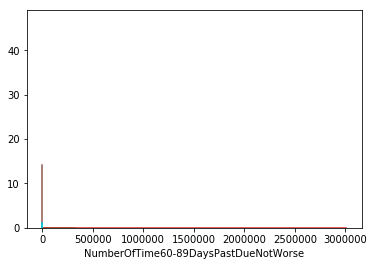

In [12]:
sns.distplot(df["age"])
sns.distplot(df["RevolvingUtilizationOfUnsecuredLines"])
sns.distplot(df["DebtRatio"])

sns.distplot(df["MonthlyIncome"])

sns.distplot(df["NumberOfOpenCreditLinesAndLoans"])
sns.distplot(df["SeriousDlqin2yrs"])

sns.distplot(df["NumberOfTime30-59DaysPastDueNotWorse"])
sns.distplot(df["NumberOfDependents"])
sns.distplot(df["NumberOfTimes90DaysLate"])

sns.distplot(df["NumberRealEstateLoansOrLines"])
sns.distplot(df["NumberOfTime60-89DaysPastDueNotWorse"])